In [1]:
%matplotlib inline

import os
import pickle
import torch
import numpy as np
import d2l.torch as d2l

from torch import nn
from torch.utils import data
from typing import Any, Dict, Tuple, Union, List

from utils.utils import evaluate_loss, load_tensor_array
from utils.trainer import train_epoch

In [2]:
data_folder_path: str = os.path.join('..', '..', 'data', 'weight_decay')

# Verify how polynomials order effects fitting

## Load Data

In [3]:
with open(os.path.join(data_folder_path, 'polynomials_order_data.pkl'), 'rb') as f:
    pkl_data: Dict[str, Union[torch.Tensor, int]] = pickle.load(f)

In [4]:
print(pkl_data.keys())
print(*[f"{key}: {value_type}" for key, value_type in zip(pkl_data.keys(), map(type, pkl_data.values()))], sep='\n')

dict_keys(['max_degree', 'poly_features', 'labels', 'train_size'])
max_degree: <class 'int'>
poly_features: <class 'torch.Tensor'>
labels: <class 'torch.Tensor'>
train_size: <class 'int'>


In [5]:
max_degree: int = pkl_data['max_degree']
poly_features: torch.Tensor = pkl_data['poly_features']
labels: torch.Tensor = pkl_data['labels']
train_size: int = pkl_data['train_size']

## Build Model Architecture

In [6]:
# Build Polynomial Regression Model
polynomial_regression: Any = lambda input_nums: nn.Sequential(nn.Linear(input_nums, 1, bias=False))

## Build Train Procedure

In [7]:
# Setup hyper-parameters
num_epochs: int = 1_000
batch_size: int = 8
lr: float = 1e-2
net: Any = polynomial_regression
loss: Any = nn.MSELoss(reduction='mean')    # Use MSE as the loss function
trainer: Any = torch.optim.SGD # Use SGD as the optimizer

In [8]:
def train(
        train_data: Tuple[torch.Tensor, torch.Tensor],
        test_data: Tuple[torch.Tensor, torch.Tensor],
        num_epochs: int, batch_size: int,
        net: Any, loss: Any, trainer: Any,
) -> np.ndarray:
    """Train the polynomial regression model."""
    # Unpack the training and testing data
    train_features, train_labels = train_data
    test_features, test_labels = test_data
    # Setup model and optimizer
    net = net(train_features.shape[-1])
    trainer = trainer(net.parameters(), lr=lr)
    # Create data loaders for training and testing
    batch_size: int = min(batch_size, train_labels.shape[0])
    train_iter: data.Dataset = load_tensor_array((train_features, train_labels.reshape((-1, 1))), batch_size, is_train=True)
    test_iter: data.Dataset = load_tensor_array((test_features, test_labels.reshape((-1, 1))), batch_size, is_train=False)
    # Initialize the animator for plotting
    animator: d2l.Animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                                            xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
    # Train the model
    for epoch in range(num_epochs):
        train_epoch(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    # Return trained weights
    return net[0].weight.data.numpy()

In [9]:
lambda_train = lambda item_num: train(
    (poly_features[:train_size, :item_num], labels[:train_size]),
    (poly_features[train_size:, :item_num], labels[train_size:]),
    num_epochs, batch_size=batch_size,
    net=net, loss=loss, trainer=trainer
)

## Verify Training Results

**Third-order polynomials fitting → Well-fitting / Good fit**

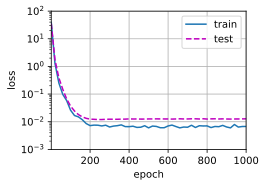

In [10]:
_ = lambda_train(item_num=3 + 1)

**First-order polynomials (linear function) fitting → Underfitting**

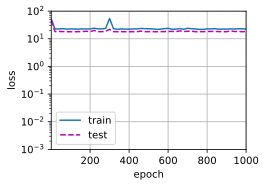

In [11]:
_ = lambda_train(item_num=1 + 1)

**High-order polynomials fitting → Overfitting**

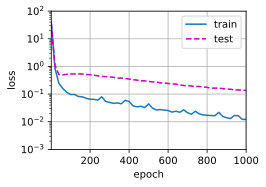

In [12]:
_ = lambda_train(item_num=max_degree)

# Verify regularization technique -- weight decay

## Load Data

In [3]:
# Loda data from .pkl file
with open(os.path.join(data_folder_path, 'weight_decay.pkl'), 'rb') as f:
    pkl_data: Dict[str, Any] = pickle.load(f)

In [4]:
print(pkl_data.keys())
print(*[f"{key}: {value_type}" for key, value_type in zip(pkl_data.keys(), map(type, pkl_data.values()))], sep='\n')

dict_keys(['train_data', 'test_data', 'num_inputs'])
train_data: <class 'tuple'>
test_data: <class 'tuple'>
num_inputs: <class 'int'>


In [5]:
# Unpack the data
train_data: Tuple[torch.Tensor, torch.Tensor] = pkl_data['train_data']
test_data: Tuple[torch.Tensor, torch.Tensor] = pkl_data['test_data']
num_inputs: int = pkl_data['num_inputs']

In [6]:
# Build data loaders
batch_size: int = 256
train_iter: data.Dataset = load_tensor_array(train_data, batch_size, is_train=True)
test_iter: data.Dataset = load_tensor_array(test_data, batch_size, is_train=False)

## Implement from nothing

### Build Model Architecture

> Implement Linear Regression with weight decay from nothing.

In [7]:
# Linear Regression
def linreg(X: torch.Tensor, w: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """Linear regression model."""
    return X @ w + b

In [8]:
# Initialize model parameters
def init_params(num_inputs: int = num_inputs) -> List[torch.Tensor]:
    """Initialize model parameters."""
    w: torch.Tensor = torch.normal(0, 0.01, size=(num_inputs, 1), requires_grad=True)
    b: torch.Tensor = torch.zeros(1, requires_grad=True)
    return [w, b]

In [9]:
# L2 Regularization
def l2_penalty(w: torch.Tensor) -> torch.Tensor:
    """L2 regularization."""
    return (w ** 2).sum() / 2

### Build Train Procedure

In [10]:
# SGD Optimizer
def sgd(params: List[torch.Tensor], lr: float) -> None:
    """Stochastic Gradient Descent (SGD) optimizer."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad
            param.grad.zero_()  # Reset gradients after updating parameters

In [11]:
# Setup hyper-parameters
num_epochs: int = 1_000
lr: float = 3e-3
net: Any = linreg
loss: Any = nn.MSELoss(reduction='mean')    # Use MSE as the loss function
trainer: Any = lambda params: sgd(params, lr)  # Use SGD as the optimizer

In [ ]:
# Build Train Procedure
def train_from_nothing(
    net: Any, num_epochs: int, num_inputs: int,
    loss: Any, trainer: Any, wd: float,
) -> float:
    """Implement from nothing."""
    # Initialize parameters
    w, b = init_params(num_inputs)
    net = lambda X: linreg(X, w, b)
    # Initialize the animator for plotting
    animator: d2l.Animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                                            xlim=[5, num_epochs], legend=['train', 'test'])
    # Train the model
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l: torch.Tensor = loss(net(X), y) + wd * l2_penalty(w)
            l.sum().backward()
            trainer([w, b])
        if epoch == 0 or (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    # Return the norm of the weight vector
    return w.norm().item()

In [ ]:
lambda_train_from_nothing: Any = lambda wd: train_from_nothing(net, num_epochs, num_inputs, loss, trainer, wd)

### Verify Train Results

**Train without regularization → Overfitting**

0.13907544314861298

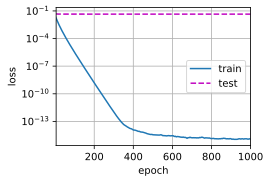

In [56]:
lambda_train_from_nothing(wd=0.0)   # Train without regularization

**Train with regularization → Alleviate Overfitting Effectively**

0.002961939899250865

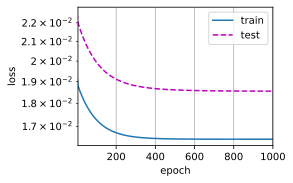

In [15]:
lambda_train_from_nothing(wd=300)

## Implement by PyTorch

### Build Model Architecture

In [31]:
# Linear Regression
nn_linreg: Any = nn.Sequential(nn.Linear(num_inputs, 1))

### Build Train Procedure

In [32]:
# Setup hyper-parameters
num_epochs: int = 1_000
lr: float = 3e-3
net: Any = nn_linreg
loss: Any = nn.MSELoss(reduction='mean')    # Use MSE as the loss function
trainer: Any = torch.optim.SGD  # Use SGD as the optimizer

In [36]:
# Build Train Procedure
def train_by_pytorch(
    net: Any, num_epochs: int, lr: float,
    loss: Any, trainer: Any, wd: float,
) -> float:
    """Train the model using PyTorch."""
    # Initialize model and optimizer
    for param in net.parameters():
        param.data.normal_(0, 1e-2)
    trainer = trainer([
        {'params': net[0].weight, 'weight_decay': wd},
        {'params': net[0].bias},     # Usually bias is not regularized
    ], lr=lr)
    # Initialize the animator for plotting
    animator: d2l.Animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                                            xlim=[5, num_epochs], legend=['train', 'test'])
    # Train the model
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()  # Reset gradients
            l: torch.Tensor = loss(net(X), y)
            l.backward()
            trainer.step()
        if epoch == 0 or (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    return net[0].weight.norm().item()

In [37]:
lambda_train_by_pytorch: Any = lambda wd: train_by_pytorch(net, num_epochs, lr, loss, trainer, wd)

### Verify Train Results

**Train without regularization → Overfitting**

0.14354555308818817

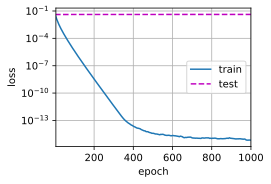

In [38]:
lambda_train_by_pytorch(wd=0.0)   # Train without regularization

**Train with regularization → Alleviate Overfitting Effectively**

0.0029619215056300163

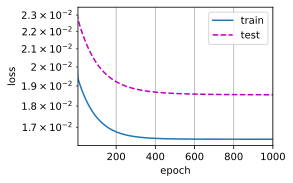

In [40]:
lambda_train_by_pytorch(wd=300)